In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
from collections import defaultdict
from datetime import timedelta
import matplotlib.pyplot as plt

csv_file = '/content/drive/MyDrive/fps_anomi_samples.csv'
df = pd.read_csv(csv_file)
df = df.drop(columns=['Unnamed: 0', 'Id'])
df = df[:50000]
df = (df - df.mean()) / df.std()

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(26, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 26),
            nn.ReLU()
        )

    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

batch_size = 256
lr = 1e-3
w_d = 1e-5
momentum = 0.9
epochs = 15

class Loader(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super(Loader, self).__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        data = torch.from_numpy(np.array(row)).float()
        return data

class Train_Loader(Loader):
    def __init__(self, dataset):
        super(Train_Loader, self).__init__(dataset)

train_set = Train_Loader(df)
train = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=True
        )

metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=w_d)

model.train()
start = time.time()

for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0

    for bx, data in enumerate(train):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_set)
    metrics['train_loss'].append(epoch_loss)

    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1, epochs, epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end - ep_start)))

end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end - start)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.00365348880648613
Epoch Complete in 0:00:06.534452
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.003354360613822937
Epoch Complete in 0:00:04.917737
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0031134950840473177
Epoch Complete in 0:00:05.595026
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0029698776721954344
Epoch Complete in 0:00:06.397988
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0028867790734767914
Epoch Complete in 0:00:04.871723
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0028551133692264557
Epoch Complete in 0:00:05.945250
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0028328610622882842
Epoch Complete in 0:00:06.203400
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.0028174988615512846
Epoch Complete in 0:00:06.490282
-------------------

이상치로 의심되는 유저 샘플 인덱스: [290, 3562, 11591, 16176, 34154]


,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_headshot_rate
290,290,290,840212,290,0,0,364.00,0,1,0,...,1977.0,3,0.0,0,0,167.8,2,1500,0.9286,0.25
3562,3562,3562,1127317,3562,0,4,428.20,0,1,3,...,4851.0,3,0.0,0,0,2268.0,7,1500,0.8370,0.20
11591,11591,11591,71306,11591,0,0,309.80,3,0,0,...,8239.0,4,0.0,0,0,749.9,1,1500,0.6667,0.00
16176,16176,16176,273316,16176,2,7,357.60,2,1,13,...,4350.0,0,0.0,0,3,3529.0,6,1498,1.0000,0.25
34154,34154,34154,1062242,34154,0,0,69.08,1,0,0,...,2934.0,3,0.0,0,0,1284.0,4,1489,0.5926,0.00


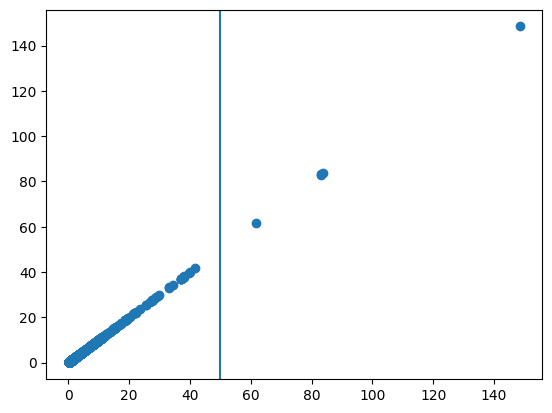

In [20]:
# 이상 감지 모델 정의
class AnomalyDetectionModel(nn.Module):
    def __init__(self):
        super(AnomalyDetectionModel, self).__init__()
        self.model = AE()

    def forward(self, x):
        return self.model(x)

model.eval()
loss_dist = []

for i in range(len(df)):
    data = torch.from_numpy(np.array(df.iloc[i][:])).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(50, 0, 1)

anomaly_indices = [i for i, loss in enumerate(loss_dist) if loss > 50]
print("이상치로 의심되는 유저 샘플 인덱스:", anomaly_indices)
csv_file = '/content/drive/MyDrive/fps_anomi_samples.csv'
df = pd.read_csv(csv_file)
df.iloc[anomaly_indices]